# House Sales for EDA and Baseline

This notebook is inspired by the `Homework` [assignment in CS 329P](https://c.d2l.ai/stanford-cs329p/assignments.html). I highly recommend yourself to finish this homework.


In this note, we will introduce the slide *Explotatory data analysis* and train a house sales price *predictor* on the data we scraped previously with AutoGluon. The purpose of this note is to let you practice different techniques that you can use to preprocess raw data. The job is to obtain the best root mean squared logarithmic error (RMSLE) on the test dataset.

**Note**: You can use either local runtimes to run our source code, or a hosted runtime (with GPU) on Colab. The second option generally runs faster. If using a local runtime, make sure that your Python version is less than 3.9 but at least 3.6, or you may have issues installing Autogluon. If using a runtime hosted on Colab, you can use the File Explorer pane on the left to upload the `house_sales.ftr` file. Make sure to wait until the file finishes uploading before running the next code block.

Additionally, if using a local runtime, please refer to the [AG document](https://auto.gluon.ai/stable/index.html#installation) for info on how to install autogluon. 


## EDA

### Loading Data
**Note** that we use the [`feather` format](https://arrow.apache.org/docs/python/feather.html), which is faster to read than CSV but uses more disk space. The file `home_sales.ftr` can be downloaded from [link](https://c.d2l.ai/stanford-cs329p/_static/house_sales.ftr).

Just for your information, it is generated with:

```python
data = pd.read_csv('house_sales.zip', dtype='unicode')
data.to_feather('house_sales.ftr')
```

The following code needs at least 2GB memory. If using a local runtime, please make sure your machine has enough memory. 

In [33]:
!pip install numpy pandas autogluon mxnet pyarrow --upgrade
import pandas as pd
import numpy as np

In [34]:
import scipy
import numpy as np
scipy.__version__, np.__version__

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
display.set_matplotlib_formats('svg')
# Alternative to set svg for newer versions
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [35]:
data = pd.read_feather('house_sales.ftr')

### Checking shape
Let's check the data shape and the first a few examples

In [36]:
data.shape

(164944, 1789)

In [37]:
data.head()

,Id,Address,Sold Price,Sold On,Summary,Type,Year built,Heating,Cooling,Parking,...,Well Disclosure,remodeled,DOH2,SerialX,Full Baths,Tax Legal Lot Number,Tax Legal Block Number,Tax Legal Tract Number,Building Name,Zip
0,2080183300,"11205 Monterey,","$2,000,000",01/31/20,"11205 Monterey, San Martin, CA 95046 is a sing...",SingleFamily,No Data,No Data,No Data,0 spaces,...,None,None,None,None,None,None,None,None,None,95046
1,20926300,"5281 Castle Rd,","$2,100,000",02/25/21,Spectacular Mountain and incredible L.A. City ...,SingleFamily,1951,Central,"Central Air, Dual","Driveway, Driveway - Brick",...,None,None,None,None,None,None,None,None,None,91011
2,19595300,"3581 Butcher Dr,","$1,125,000",11/06/19,Eichler Style home! with Santa Clara High! in ...,SingleFamily,1954,Central Forced Air - Gas,Central AC,"Garage, Garage - Attached, Covered",...,None,None,None,None,None,None,None,None,None,95051
3,300472200,"2021 N Milpitas Blvd,","$36,250,000",10/02/20,"2021 N Milpitas Blvd, Milpitas, CA 95035 is a ...",Apartment,1989,Other,No Data,"Mixed, Covered",...,None,None,None,None,None,None,None,None,None,95035
4,2074492000,"LOT 4 Tool Box Spring Rd,","$140,000",10/19/20,Beautiful level lot dotted with pine trees ro...,VacantLand,No Data,No Data,No Data,0 spaces,...,None,None,None,None,None,None,None,None,None,92561


### Null Values
Drop columns that at least 30% values are null to simplify our EDA

In [38]:
null_sum = data.isnull().sum()
data.columns[null_sum < len(data) * 0.3]  # columns will keep

Index(['Id', 'Address', 'Sold Price', 'Sold On', 'Summary', 'Type',
       'Year built', 'Heating', 'Cooling', 'Parking', 'Bedrooms', 'Bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Home type', 'Region', 'Elementary School', 'Elementary School Score',
       'Elementary School Distance', 'High School', 'High School Score',
       'High School Distance', 'Heating features', 'Parking features',
       'Lot size', 'Parcel number', 'Tax assessed value', 'Annual tax amount',
       'Listed On', 'Listed Price', 'Zip'],
      dtype='object')

To reduce the memory, we set the inplace `parameter` to `True`

In [39]:
data.drop(columns=data.columns[null_sum > len(data) * 0.3], inplace=True)

### Data Types

Now, we check the data types. You can find some obvious mistakes in this step.


In [40]:
data.dtypes

Id                             object
Address                        object
Sold Price                     object
Sold On                        object
Summary                        object
Type                           object
Year built                     object
Heating                        object
Cooling                        object
Parking                        object
Bedrooms                       object
Bathrooms                      object
Total interior livable area    object
Total spaces                   object
Garage spaces                  object
Home type                      object
Region                         object
Elementary School              object
Elementary School Score        object
Elementary School Distance     object
High School                    object
High School Score              object
High School Distance           object
Heating features               object
Parking features               object
Lot size                       object
Parcel numbe

Convert currency from string format as `$1,000,000` to float

In [41]:
currency = ['Sold Price', 'Listed Price', 'Tax assessed value', 'Annual tax amount']
for c in currency:
    data[c] = data[c].replace(
        r'[$,-]', '', regex=True).replace(
        r'^\s*$', np.nan, regex=True).astype(float)

Also convert areas from string format such as 1000 sqft and 1 Acres to float as well.


In [42]:
areas = ['Total interior livable area', 'Lot size']
for c in areas:
    acres = data[c].str.contains('Acres') == True
    col = data[c].replace(r'\b sqft\b|\b Acres\b|\b,\b','', regex=True).astype(float)
    col[acres] *= 43560
    data[c] = col


### Data Filter
Now we can check values of the numerical columns. You could see the min and max values for several columns do not make sense.


In [43]:
data.describe()

,Sold Price,Total interior livable area,Lot size,Tax assessed value,Annual tax amount,Listed Price
count,1.648590e+05,1.465450e+05,1.358450e+05,1.450650e+05,1.433500e+05,1.250060e+05
mean,1.194842e+06,3.182221e+03,9.525061e+05,8.898781e+05,1.123415e+04,1.197671e+06
std,3.336365e+06,4.609881e+05,1.357197e+08,3.126888e+06,3.859389e+04,2.874721e+06
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,4.350000e+05,1.170000e+03,4.800000e+03,2.550000e+05,3.434250e+03,4.990000e+05
50%,8.050000e+05,1.558000e+03,6.603000e+03,5.635010e+05,7.372000e+03,8.490000e+05
75%,1.370000e+06,2.144000e+03,1.209000e+04,1.033832e+06,1.321300e+04,1.395000e+06
max,8.660000e+08,1.764164e+08,4.856770e+10,8.256328e+08,9.977342e+06,6.250000e+08


We filter out houses whose living areas are too small or too hard to simplify the visualization later.


In [44]:
abnormal = (data[areas[1]] < 10) | (data[areas[1]] > 1e4)
data = data[~abnormal]
sum(abnormal)

41000

### Data Visualization


Let's check the histogram of the `'Sold Price'`, which is the target we want to predict.

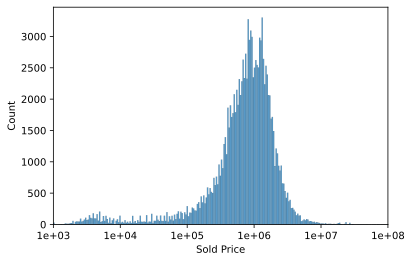

In [45]:
ax = sns.histplot(np.log10(data['Sold Price']))
ax.set_xlim([3, 8])
ax.set_xticks(range(3, 9))
ax.set_xticklabels(['%.0e'%a for a in 10**ax.get_xticks()]);

A house has different types. Here are the top types:

In [46]:
data['Type'].value_counts()[0:20]

SingleFamily            74318
Condo                   18749
MultiFamily              6586
VacantLand               6199
Townhouse                5846
Unknown                  5390
MobileManufactured       2588
Apartment                1416
Cooperative               161
Residential Lot            75
Single Family              69
Single Family Lot          56
Acreage                    48
2 Story                    39
3 Story                    25
Hi-Rise (9+), Luxury       21
RESIDENTIAL                19
Duplex                     19
Condominium                19
Mid-Rise (4-8)             17
Name: Type, dtype: int64

Price density for different house types.


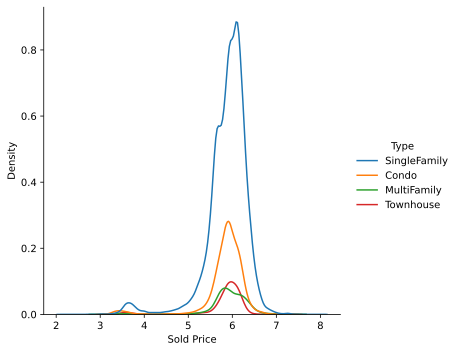

In [47]:
types = data['Type'].isin(['SingleFamily', 'Condo', 'MultiFamily', 'Townhouse'])
sns.displot(pd.DataFrame({'Sold Price':np.log10(data[types]['Sold Price']),
                          'Type':data[types]['Type']}),
            x='Sold Price', hue='Type', kind='kde');

Another important measurement is the sale price per living sqft. Let's check the differences between different house types.


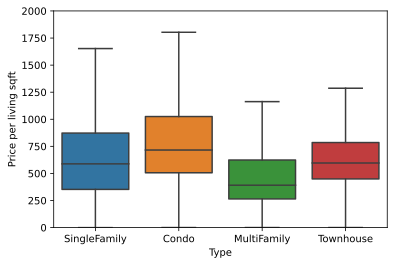

In [48]:
data['Price per living sqft'] = data['Sold Price'] / data['Total interior livable area']
ax = sns.boxplot(x='Type', y='Price per living sqft', data=data[types], fliersize=0)
ax.set_ylim([0, 2000]);

We know the location affect the price. Let's check the price for the top 20 zip codes.

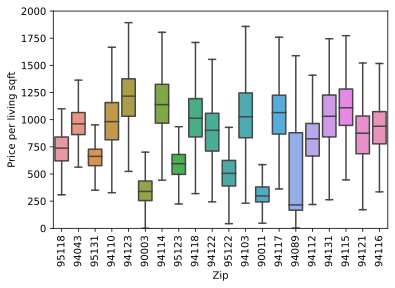

In [49]:
d = data[data['Zip'].isin(data['Zip'].value_counts()[:20].keys())]
ax = sns.boxplot(x='Zip', y='Price per living sqft', data=d, fliersize=0)
ax.set_ylim([0, 2000])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Last, we visualize the correlation matrix of several columns.


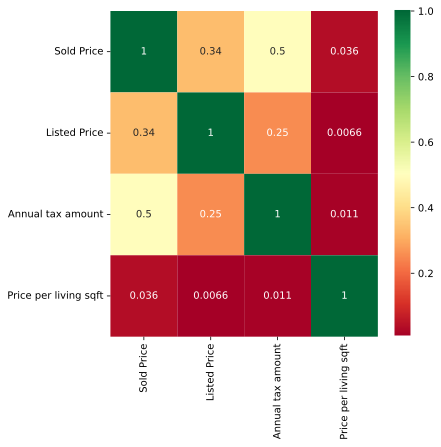

In [50]:
_, ax = plt.subplots(figsize=(6,6))
columns = ['Sold Price', 'Listed Price', 'Annual tax amount', 'Price per living sqft', 'Elementary School Score', 'High School Score']
sns.heatmap(data[columns].corr(),annot=True,cmap='RdYlGn', ax=ax);

### Summary for EDA

It demonstrates the basic technologies for EDA, including

  * Understanding column data types, values, and distributions
  * Understanding the interactions between columns

Here only explored a small aspect of the data. You are welcome to dive deep into more details. For more practice, [Kaggle](https://www.kaggle.com/competitions) is a good way for you to become a data scientist.

## Baseline Model Training

### Data Preprocessing
**Note that** we just select a few common columns to make our training fast. You can select more columns to make your model more accurate. 

In [56]:
data = pd.read_feather('house_sales.ftr')

In [57]:
df = data[['Sold Price', 'Sold On', 'Type', 'Year built', 'Bedrooms', 'Bathrooms']].copy()
# the below line to save memory
del data

Copy the code from EDA to convert `Sold Price` to numerical values, which is our prediction target. We also remove examples whose prices are too high or too low.

In [58]:
c = 'Sold Price'
if c in df.select_dtypes('object').columns:
    df.loc[:,c] = np.log10(
            pd.to_numeric(df[c].replace(r'[$,-]', '', regex=True)) + 1)
df = df[(df['Sold Price'] >= 4 ) & (df['Sold Price'] <= 8 )]

We use the house sales between 2021-2-15 and 2021-3-1 as our test data. You can use any example before 2021-2-15, but not after. In other words, we pretend we are launching our model on 2021-2-15 and testing it for 2 weeks. Here we only use sales in 2021 for fast training, but you can use more to improve accuracy. 

In [59]:
test_start, test_end = pd.Timestamp(2021, 2, 15), pd.Timestamp(2021, 3, 1)
train_start = pd.Timestamp(2021, 1, 1)
df['Sold On'] = pd.to_datetime(df['Sold On'], errors='coerce')
train = df[(df['Sold On'] >= train_start) & (df['Sold On'] < test_start)]
test = df[(df['Sold On'] >= test_start) & (df['Sold On'] < test_end)]
train.shape, test.shape

((24872, 6), (11510, 6))

Define our evaluation metric. 

In [60]:
def rmsle(y_hat, y):
    # we already used log prices before, so we only need to compute RMSE
    return sum((y_hat - y)**2 / len(y))**0.5

### AutoGluon Baseline
Here provide a baseline model trained by AutoGluon (AG). AG is an automl tool that performs automatic feature engineering, model selections, and ensemble.

In [61]:
from autogluon.tabular import TabularPredictor
    
label = 'Sold Price'    
predictor = TabularPredictor(label=label).fit(train)

No path specified. Models will be saved in: "AutogluonModels/ag-20220305_144444/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220305_144444/"
AutoGluon Version:  0.3.1
Train Data Rows:    24872
Train Data Columns: 5
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (7.546542675816042, 4.000043427276863, 5.75084, 0.39719)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4962.57 MB
	Train Data (Original)  Memory Usage: 6.32 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata

[1000]	train_set's rmse: 0.279427	valid_set's rmse: 0.288174


	-0.288	 = Validation score   (root_mean_squared_error)
	5.24s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: LightGBM ...
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-0.2906	 = Validation score   (root_mean_squared_error)
	0.74s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.3112	 = Validation score   (root_mean_squared_error)
	12.81s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: CatBoost ...
	-0.2872	 = Validation score   (root_mean_squared_error)
	16.83s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.3085	 = Validation score   (root_mean_squared_error)
	7.19s	 = Traini

Test the performance of each model. 

In [62]:
predictor.leaderboard(test, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,-0.263843,-0.290615,0.241864,0.036025,0.736995,0.241864,0.036025,0.736995,1,True,2
1,LightGBMXT,-0.264661,-0.287976,1.664793,0.295300,5.235539,1.664793,0.295300,5.235539,1,True,1
2,NeuralNetFastAI,-0.267478,-0.290814,0.387971,0.075925,40.225805,0.387971,0.075925,40.225805,1,True,6
3,NeuralNetMXNet,-0.272254,-0.295055,1.389710,0.312505,141.389029,1.389710,0.312505,141.389029,1,True,8
4,LightGBMLarge,-0.284622,-0.289437,0.197520,0.049665,1.174564,0.197520,0.049665,1.174564,1,True,9
5,WeightedEnsemble_L2,-0.299157,-0.286223,3.916451,0.741385,72.005815,0.010767,0.000727,0.345753,2,True,10
6,ExtraTreesMSE,-0.313275,-0.308541,1.498187,0.309434,7.187057,1.498187,0.309434,7.187057,1,True,5
7,CatBoost,-0.321927,-0.287176,0.084655,0.024602,16.834903,0.084655,0.024602,16.834903,1,True,4
8,RandomForestMSE,-0.378744,-0.311239,1.610636,0.307098,12.810498,1.610636,0.307098,12.810498,1,True,3
9,XGBoost,-0.379600,-0.290175,0.270078,0.035398,2.176758,0.270078,0.035398,2.176758,1,True,7


Next, we compute the importance of each feature, along with several other metrics. It loooks like the `Sold On` feature is not very useful, likely because the houses in the test data were all sold late. You can choose to either remove such a feature, or find a way to extract a more useful presentation from it.

In [66]:
predictor.feature_importance(test)

Computing feature importance via permutation shuffling for 5 features using 1000 rows with 3 shuffle sets...
	20.25s	= Expected runtime (6.75s per shuffle set)
	12.53s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Type,0.073467,0.004029,0.000501,3,0.096556,0.050378
Bathrooms,0.069163,0.006243,0.001353,3,0.104939,0.033388
Year built,0.046939,0.006333,0.003007,3,0.083228,0.010650
Bedrooms,0.016702,0.003391,0.006732,3,0.036133,-0.002729
Sold On,0.000010,0.000017,0.203002,3,0.000106,-0.000086


Finally, let's predict and evaluate the RMSLE.

In [67]:
preds = predictor.predict(test.drop(columns=[label]))
rmsle(preds, test[label])

0.29915659453670335